### CAPSTONE PROJECT 1 - PREDICTING THE HEALTH OF STREET TREES IN NEW YORK CITY

The documents describing this project can be found in the same repository.
The dataset used in this project has been downloaded locally and imported. It can be found at the following address:
https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

DATA WRANGLING AND CLEAN UP

In [1]:
# Import relevant modules
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
import scipy.stats as scs

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from sklearn.decomposition import PCA


In [2]:
# Import dataset
df=pd.read_csv('2015_Street_Tree_Census_Tree_Data.csv')
print('Dataset imported')

Dataset imported


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
tree_id             683788 non-null int64
block_id            683788 non-null int64
created_at          683788 non-null object
tree_dbh            683788 non-null int64
stump_diam          683788 non-null int64
curb_loc            683788 non-null object
status              683788 non-null object
health              652172 non-null object
spc_latin           652169 non-null object
spc_common          652169 non-null object
steward             652173 non-null object
guards              652172 non-null object
sidewalk            652172 non-null object
user_type           683788 non-null object
problems            652124 non-null object
root_stone          683788 non-null object
root_grate          683788 non-null object
root_other          683788 non-null object
trunk_wire          683788 non-null object
trnk_light          683788 non-null object
trnk_other          683788 non-nu

In [4]:
df.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,"4,073,900",New York,40.723092,-73.844215,"1,027,431.148","202,756.7687",29.0,739,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,"4,097,300",New York,40.794111,-73.818679,"1,034,455.701","228,644.8374",19.0,973,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,"3,044,900",New York,40.717581,-73.936608,"1,001,822.831","200,716.8913",34.0,449,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,"3,044,900",New York,40.713537,-73.934456,"1,002,420.358","199,244.2531",34.0,449,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,"3,016,500",New York,40.666778,-73.975979,"990,913.775","182,202.426",39.0,165,3025654.0,3.010850e+09


In [5]:
# Remove columns that aren't used or contains redundant information
drop_list=['tree_id','block_id','spc_latin','address','postcode','zip_city','community board','cncldist',
        'st_assem','st_senate','nta','boro_ct','state','x_sp','y_sp','council district','census tract',
        'bin','bbl']
df.drop(drop_list,axis=1,inplace=True)

In [6]:
df.head()

,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
0,08/27/2015,3,0,OnCurb,Alive,Fair,red maple,None,None,NoDamage,...,No,No,No,No,No,4,Queens,Forest Hills,40.723092,-73.844215
1,09/03/2015,21,0,OnCurb,Alive,Fair,pin oak,None,None,Damage,...,No,No,No,No,No,4,Queens,Whitestone,40.794111,-73.818679
2,09/05/2015,3,0,OnCurb,Alive,Good,honeylocust,1or2,None,Damage,...,No,No,No,No,No,3,Brooklyn,East Williamsburg,40.717581,-73.936608
3,09/05/2015,10,0,OnCurb,Alive,Good,honeylocust,None,None,Damage,...,No,No,No,No,No,3,Brooklyn,East Williamsburg,40.713537,-73.934456
4,08/30/2015,21,0,OnCurb,Alive,Good,American linden,None,None,Damage,...,No,No,No,No,No,3,Brooklyn,Park Slope-Gowanus,40.666778,-73.975979


In [7]:
# Check 'health' column, which is the target variable for the model. Remove rows that don't have an entry. 
# Check a couple of columns of interest after removal.
df.dropna(subset=['health'],axis=0,inplace=True)
df.status.describe()

count     652172
unique         1
top        Alive
freq      652172
Name: status, dtype: object

In [8]:
df['stump_diam'].describe()

count    652172.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: stump_diam, dtype: float64

In [9]:
# The above results shows that after removing the rows that don't have an 'health' entry, 
# the 'status' and 'stump diameter' variables have a unique value, so they can be removed.
df.drop(['status','stump_diam'],axis=1,inplace=True)

In [10]:
# Rename columns, drop rows with missing values if their number is very low compared to total number of entries.
df.rename(columns={'tree_dbh': 'tree_diam','spc_common':'species'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652172 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652172 non-null object
tree_diam     652172 non-null int64
curb_loc      652172 non-null object
health        652172 non-null object
species       652167 non-null object
steward       652172 non-null object
guards        652171 non-null object
sidewalk      652171 non-null object
user_type     652172 non-null object
problems      652123 non-null object
root_stone    652172 non-null object
root_grate    652172 non-null object
root_other    652172 non-null object
trunk_wire    652172 non-null object
trnk_light    652172 non-null object
trnk_other    652172 non-null object
brch_light    652172 non-null object
brch_shoe     652172 non-null object
brch_other    652172 non-null object
borocode      652172 non-null int64
borough       652172 non-null object
nta_name      652172 non-null object
latitude      652172 non-null float64
longitude     652172 non-null float64
d

In [11]:
df.dropna(subset=['species','guards','sidewalk','problems'],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652118 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652118 non-null object
tree_diam     652118 non-null int64
curb_loc      652118 non-null object
health        652118 non-null object
species       652118 non-null object
steward       652118 non-null object
guards        652118 non-null object
sidewalk      652118 non-null object
user_type     652118 non-null object
problems      652118 non-null object
root_stone    652118 non-null object
root_grate    652118 non-null object
root_other    652118 non-null object
trunk_wire    652118 non-null object
trnk_light    652118 non-null object
trnk_other    652118 non-null object
brch_light    652118 non-null object
brch_shoe     652118 non-null object
brch_other    652118 non-null object
borocode      652118 non-null int64
borough       652118 non-null object
nta_name      652118 non-null object
latitude      652118 non-null float64
longitude     652118 non-null float64
d

In [12]:
df.problems.describe()

count     652118
unique       232
top         None
freq      426276
Name: problems, dtype: object

In [13]:
# Analyze the only numerical feature, apart form langitude, latitude and borocode
df.tree_diam.describe()

count    652118.000000
mean         11.709684
std           8.634257
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_diam, dtype: float64

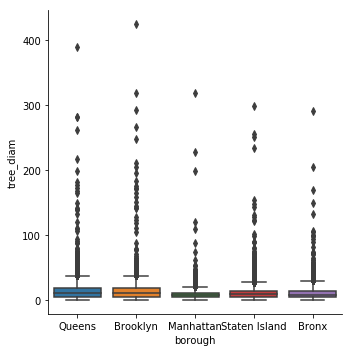

In [14]:
sns.catplot(x="borough", y="tree_diam", kind="box", data=df)

In [15]:
df.groupby('borough')['tree_diam'].max()

borough
Bronx            291
Brooklyn         425
Manhattan        318
Queens           389
Staten Island    298
Name: tree_diam, dtype: int64

In [16]:
df.groupby('species')['tree_diam'].max().sort_values(ascending=False)

species
swamp white oak          425
tulip-poplar             389
London planetree         318
pin oak                  318
Callery pear             298
cherry                   291
littleleaf linden        266
mulberry                 217
Japanese zelkova         210
Norway maple             204
willow oak               199
black locust             177
crimson king maple       172
honeylocust              169
silver maple             168
green ash                159
red maple                154
Siberian elm             149
Sophora                  141
sweetgum                 128
Chinese elm              118
ginkgo                   106
eastern redcedar          99
Schumard's oak            91
Atlantic white cedar      89
northern red oak          76
American elm              65
black oak                 64
crab apple                64
eastern cottonwood        64
                        ... 
European alder            29
kousa dogwood             28
serviceberry              28
paper 

In [17]:
df.groupby('species')['tree_diam'].median().sort_values(ascending=False)[:20]

species
London planetree      22.0
silver maple          21.0
pin oak               17.0
eastern cottonwood    16.0
horse chestnut        15.0
pignut hickory        15.0
weeping willow        14.0
Norway maple          14.0
sycamore maple        14.0
ash                   13.0
catalpa               13.0
green ash             13.0
white ash             12.0
mulberry              11.0
white pine            11.0
sugar maple           11.0
maple                 11.0
tree of heaven        11.0
black locust          11.0
willow oak            10.0
Name: tree_diam, dtype: float64

In [18]:
df.groupby('species')['tree_diam'].mean().sort_values(ascending=False)[:20]

species
London planetree      21.560900
silver maple          21.017927
eastern cottonwood    17.061594
pin oak               16.867053
weeping willow        15.797872
pignut hickory        15.393939
sycamore maple        14.767118
Norway maple          14.330516
catalpa               14.284936
mulberry              14.219533
horse chestnut        14.015511
ash                   13.684553
green ash             13.566338
white ash             12.672614
tree of heaven        12.664021
white pine            12.569307
willow oak            12.279209
black locust          12.192825
American elm          11.953229
sassafras             11.807018
Name: tree_diam, dtype: float64

In [19]:
# Diameter values above 100 are suspicious. They are reported across all boroughs and for more than 1 species.
# It is considered a typo or wrong entry. 
# A threshold of 90 is used to filter, the entries above this value are removed, since they are a small percentage
# of the data.
df_tree=df[df['tree_diam']<=90]
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652044 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652044 non-null object
tree_diam     652044 non-null int64
curb_loc      652044 non-null object
health        652044 non-null object
species       652044 non-null object
steward       652044 non-null object
guards        652044 non-null object
sidewalk      652044 non-null object
user_type     652044 non-null object
problems      652044 non-null object
root_stone    652044 non-null object
root_grate    652044 non-null object
root_other    652044 non-null object
trunk_wire    652044 non-null object
trnk_light    652044 non-null object
trnk_other    652044 non-null object
brch_light    652044 non-null object
brch_shoe     652044 non-null object
brch_other    652044 non-null object
borocode      652044 non-null int64
borough       652044 non-null object
nta_name      652044 non-null object
latitude      652044 non-null float64
longitude     652044 non-null float64
d

In [20]:
#df_tree[df_tree.duplicated(['species','tree_diam','created_at'])]
df_tree[df_tree.duplicated()]

,created_at,tree_diam,curb_loc,health,species,steward,guards,sidewalk,user_type,problems,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
62722,09/16/2015,28,OnCurb,Good,London planetree,None,None,Damage,TreesCount Staff,Stones,...,No,No,No,No,No,3,Brooklyn,Midwood,40.615966,-73.956801
184923,10/26/2015,3,OnCurb,Good,sawtooth oak,1or2,None,NoDamage,Volunteer,None,...,No,No,No,No,No,4,Queens,Woodside,40.748463,-73.910383
271605,11/28/2015,9,OnCurb,Good,Sophora,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,3,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,40.693128,-73.986285
273114,11/28/2015,9,OnCurb,Good,Sophora,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,3,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,40.693094,-73.985292
276682,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278174,12/04/2015,12,OnCurb,Good,Callery pear,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278356,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278413,12/04/2015,6,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278459,12/04/2015,9,OnCurb,Good,pin oak,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278500,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861


In [21]:
df_tree.drop_duplicates()
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652044 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652044 non-null object
tree_diam     652044 non-null int64
curb_loc      652044 non-null object
health        652044 non-null object
species       652044 non-null object
steward       652044 non-null object
guards        652044 non-null object
sidewalk      652044 non-null object
user_type     652044 non-null object
problems      652044 non-null object
root_stone    652044 non-null object
root_grate    652044 non-null object
root_other    652044 non-null object
trunk_wire    652044 non-null object
trnk_light    652044 non-null object
trnk_other    652044 non-null object
brch_light    652044 non-null object
brch_shoe     652044 non-null object
brch_other    652044 non-null object
borocode      652044 non-null int64
borough       652044 non-null object
nta_name      652044 non-null object
latitude      652044 non-null float64
longitude     652044 non-null float64
d

In [22]:
df_tree.reset_index(drop=True,inplace=True)
df_tree.tail()

,created_at,tree_diam,curb_loc,health,species,steward,guards,sidewalk,user_type,problems,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
652039,08/18/2015,25,OnCurb,Good,pin oak,None,None,Damage,Volunteer,None,...,No,No,No,No,No,3,Brooklyn,North Side-South Side,40.713211,-73.954944
652040,08/29/2015,7,OnCurb,Good,Kentucky yellowwood,1or2,None,NoDamage,Volunteer,None,...,No,No,No,No,No,4,Queens,Forest Hills,40.715194,-73.856650
652041,08/22/2015,12,OnCurb,Good,red maple,None,None,Damage,Volunteer,None,...,No,No,No,No,No,5,Staten Island,Westerleigh,40.620762,-74.136517
652042,08/29/2015,9,OnCurb,Good,red maple,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,2,Bronx,Mount Hope,40.850828,-73.903115
652043,09/03/2015,23,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,4,Queens,Fresh Meadows-Utopia,40.732165,-73.787526


EXPLORE DATA

Plot trees health and count vs location and other features (for example position, steward).

In [23]:
# Set color palette for plots as 'colorblind'
bcol=sns.color_palette('colorblind').as_hex()
sns.set_palette("colorblind")

Text(0, 0.5, 'Count')

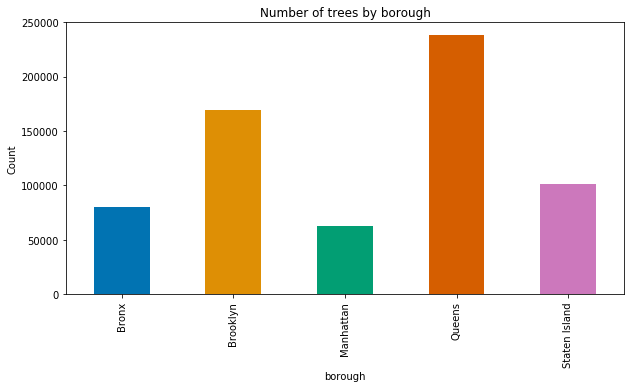

In [24]:
df_tree.groupby('borough')['tree_diam'].count().plot(kind='bar',color=bcol,figsize=(10,5))
plt.title('Number of trees by borough')
plt.ylabel('Count')

The first plot already shows something interesting: the highest numerb of tress isn't in Manhattan, where Central Park is located, but in Queens! Manhattan has the lowest number of trees.

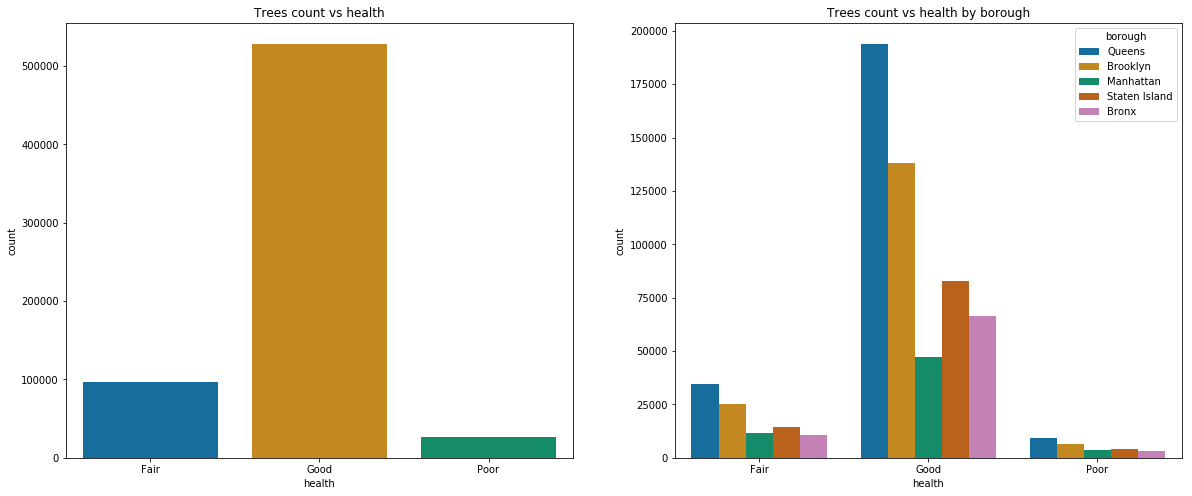

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sns.catplot(x="health", kind="count", data=df_tree,ax=axes[0])
axes[0].set_title('Trees count vs health')
sns.catplot(x="health", kind="count", hue='borough',data=df_tree,ax=axes[1])
axes[1].set_title('Trees count vs health by borough')
plt.close(2)
plt.close(3)

The data set is skewed towards the "good" health, so it will probably need to be balanced when creating a predictive model.
This is true if both looking at the overall trees' count and by borough. It is also confirmed by the fact that the order of borough by trees count is the same, reagrdless of health.  

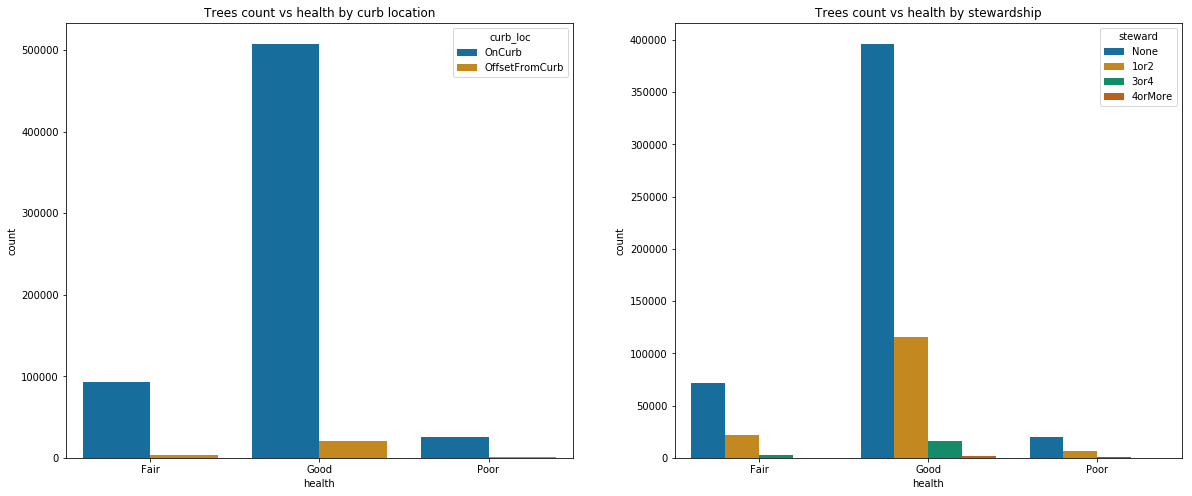

In [26]:
fig1, axes1 = plt.subplots(1, 2, figsize=(20,8))
sns.catplot(x="health", kind="count", hue='curb_loc', data=df_tree,ax=axes1[0])
axes1[0].set_title('Trees count vs health by curb location')
sns.catplot(x="health", kind="count", hue='steward', data=df_tree,ax=axes1[1])
axes1[1].set_title('Trees count vs health by stewardship')
plt.close(3)
plt.close(2)

Text(0.5, 1.0, 'Trees count vs user type and health')

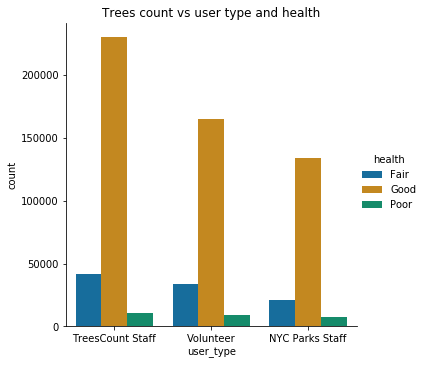

In [27]:
sns.catplot(x="user_type", kind="count", hue='health', data=df_tree)
plt.title('Trees count vs user type and health')

The fact that trees have been attended to or not, and by whom, volunteers or staff, doesn't affect the health status. The trends are confirmed. 

Plot trees' diameter vs location, health.

In [28]:
# Plot diameter vs borough and health after grouping and applying custom function
bor_group=df_tree.groupby('borough')
bor_list=list(bor_group.groups.keys())
health_group=df_tree.groupby('health')
health_list=list(health_group.groups.keys())

def avg_diam(group):
    diam=[group['tree_diam'].mean().round(1) for k,group in group]
    return(diam)

Text(0, 0.5, 'Diameter')

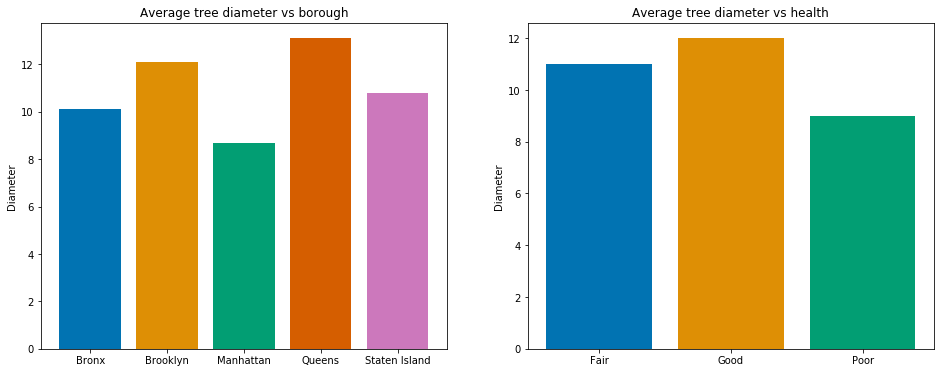

In [29]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.bar(range(len(bor_group.groups)),avg_diam(bor_group),tick_label=bor_list,color=bcol)
plt.title('Average tree diameter vs borough')
plt.ylabel('Diameter')
plt.subplot(1,2,2)
plt.bar(range(len(health_group.groups)),avg_diam(health_group),tick_label=health_list,color=bcol)
plt.title('Average tree diameter vs health')
plt.ylabel('Diameter')

The trees diameter plots show a couple of interesting results. The diameter follows the order of the borough by number of individuals: where there are more trees, their diameter is also bigger. Furthermore, there's a possible correlation between the diameter and the health: helthiest trees seem to have bigger diameters. The latter finding suggest the diameter is a variable to use when building the model.

A different view at trees' diameter and number vs borough and health.

In [30]:
df_hbd=df_tree[['health','borough','tree_diam']].groupby(['health','borough'])
df_hbd.groups.keys()

dict_keys([('Fair', 'Bronx'), ('Fair', 'Brooklyn'), ('Fair', 'Manhattan'), ('Fair', 'Queens'), ('Fair', 'Staten Island'), ('Good', 'Bronx'), ('Good', 'Brooklyn'), ('Good', 'Manhattan'), ('Good', 'Queens'), ('Good', 'Staten Island'), ('Poor', 'Bronx'), ('Poor', 'Brooklyn'), ('Poor', 'Manhattan'), ('Poor', 'Queens'), ('Poor', 'Staten Island')])

In [31]:
hl=[]
bl=[]
cl=[]
dl=[]
for name,group in df_hbd: 
    print(name,len(group.index), group['tree_diam'].mean().round(1))
    hl.append(name[0])
    bl.append(name[1])
    cl.append(len(group.index))
    dl.append(group['tree_diam'].mean().round(1))

('Fair', 'Bronx') 10885 9.2
('Fair', 'Brooklyn') 25067 11.3
('Fair', 'Manhattan') 11457 8.1
('Fair', 'Queens') 34540 12.6
('Fair', 'Staten Island') 14533 10.2
('Good', 'Bronx') 66592 10.3
('Good', 'Brooklyn') 138186 12.5
('Good', 'Manhattan') 47351 9.0
('Good', 'Queens') 193987 13.3
('Good', 'Staten Island') 82635 11.0
('Poor', 'Bronx') 3094 7.6
('Poor', 'Brooklyn') 6457 8.7
('Poor', 'Manhattan') 3609 6.8
('Poor', 'Queens') 9415 10.7
('Poor', 'Staten Island') 4236 8.7


In [32]:
d={'health': hl, 'borough': bl, 'trees_num': cl, 'avg_diam':dl}
nd=pd.DataFrame(d)
nd

,health,borough,trees_num,avg_diam
0,Fair,Bronx,10885,9.2
1,Fair,Brooklyn,25067,11.3
2,Fair,Manhattan,11457,8.1
3,Fair,Queens,34540,12.6
4,Fair,Staten Island,14533,10.2
5,Good,Bronx,66592,10.3
6,Good,Brooklyn,138186,12.5
7,Good,Manhattan,47351,9.0
8,Good,Queens,193987,13.3
9,Good,Staten Island,82635,11.0


In [33]:
nd['trees_norm']=(nd['trees_num']-nd['trees_num'].min())/(nd['trees_num'].max()-nd['trees_num'].min())
nd['diam_norm']=(nd['avg_diam']-nd['avg_diam'].min())/(nd['avg_diam'].max()-nd['avg_diam'].min())
nd

,health,borough,trees_num,avg_diam,trees_norm,diam_norm
0,Fair,Bronx,10885,9.2,0.040813,0.369231
1,Fair,Brooklyn,25067,11.3,0.115106,0.692308
2,Fair,Manhattan,11457,8.1,0.043810,0.200000
3,Fair,Queens,34540,12.6,0.164731,0.892308
4,Fair,Staten Island,14533,10.2,0.059924,0.523077
5,Good,Bronx,66592,10.3,0.332637,0.538462
6,Good,Brooklyn,138186,12.5,0.707684,0.876923
7,Good,Manhattan,47351,9.0,0.231842,0.338462
8,Good,Queens,193987,13.3,1.000000,1.000000
9,Good,Staten Island,82635,11.0,0.416678,0.646154


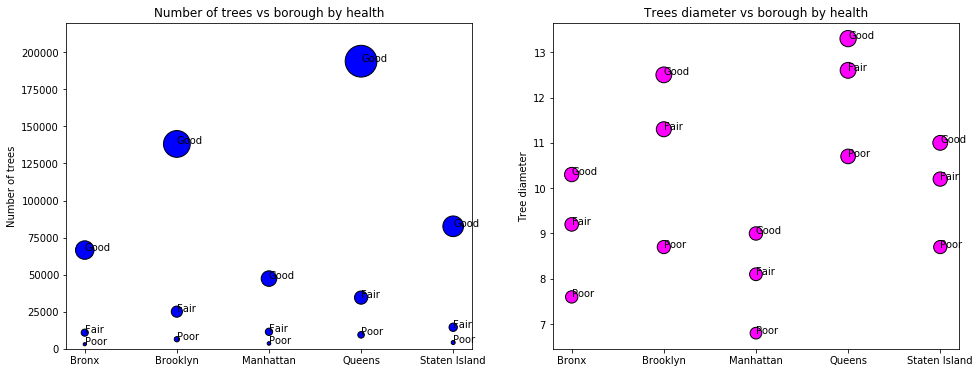

In [34]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(nd.borough,nd['trees_num'], s = nd['trees_norm']*1000+10, c='blue', linewidths=1,edgecolors='k') 
plt.title('Number of trees vs borough by health')
plt.ylabel('Number of trees')
plt.ylim([0,220000])
for i in nd.index:
    plt.annotate(nd.health[i],xy=(nd.borough[i],nd['trees_num'][i]))
plt.subplot(1,2,2)
plt.scatter(nd.borough,nd['avg_diam'],  s = nd['avg_diam']*20, c='magenta', linewidths=1, edgecolors='k') 
plt.title('Trees diameter vs borough by health')
plt.ylabel('Tree diameter')
for i in nd.index:
    plt.annotate(nd.health[i],xy=(nd.borough[i],nd['avg_diam'][i]))    

Another look at the diameter vs health and borough reveals that the same diameter is an indication of a different health, depending on where the tree is located. This suggest that it may be appropriate to apply the model separately to the different boroughs.

Analyses of species.

In [35]:
# Create separate dataframes for the different boroughs. Visualize most common species.
#bor_list=list(df_tree.borough.unique())
bor_list

['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

In [36]:
def bordf(df,name):
    df_bor=df[df.borough==name]
    df_bor.reset_index(drop=True,inplace=True)
    return(df_bor)
df_queens=bordf(df_tree,'Queens')  
df_brook=bordf(df_tree,'Brooklyn')  
df_manh=bordf(df_tree,'Manhattan') 
df_state=bordf(df_tree,'Staten Island') 
df_bronx=bordf(df_tree,'Bronx') 

Text(0.5, 0, 'Count')

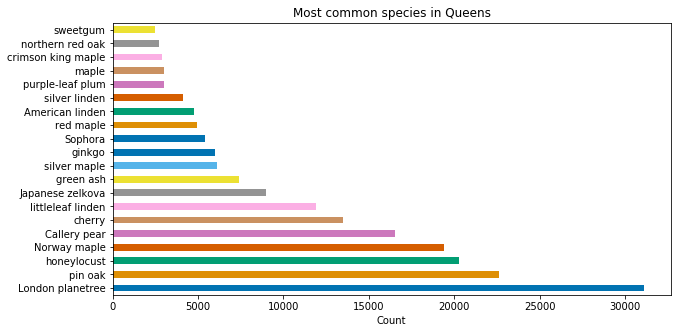

In [37]:
df_queens.species.value_counts()[:20].plot(kind='barh',figsize=(10,5))
plt.title('Most common species in Queens')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

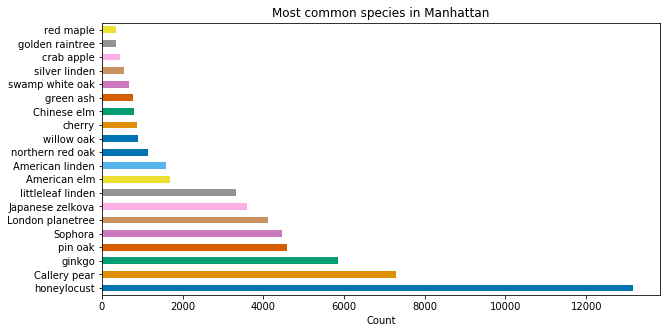

In [38]:
df_manh.species.value_counts()[:20].plot(kind='barh',figsize=(10,5))
plt.title('Most common species in Manhattan')
plt.xlabel('Count')

Although the number of trees in Queens and Manhanttan is quite different, they have some species in common. Maybe the difference is due to a different area. A quick check confirmed that Queen's land areas is approximately 5 times Manhattan's.

TEXT TO NUMERICAL CONVERSION

In [39]:
# Create a function to use for conversion of text data to numerical.
def label_enc(series):
    
    series=series.astype('category')
    new_series=series.cat.codes
    return(new_series)

# list of features to be converted
enc_list=['curb_loc', 'health','steward',
       'guards', 'sidewalk', 'user_type','root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other']

# Apply function to entire dataframe and boroughs separately

def encoder(df,enc_list):
    
    '''label encoding of list of columns of a dataframe'''
    
    df_text=df[enc_list].copy()
    df_text_enc=df_text.transform(label_enc)
    df_text_noenc=df.copy()
    df_text_noenc.drop(enc_list,axis=1,inplace=True)
    df_enc=pd.concat([df_text_noenc,df_text_enc], axis=1)
    return df_enc    

df_tree_enc=encoder(df_tree,enc_list)

queens_enc=encoder(df_queens,enc_list)  
brook_enc=encoder(df_brook,enc_list)   
manh_enc=encoder(df_manh,enc_list)   
state_enc=encoder(df_state,enc_list)  
bronx_enc=encoder(df_bronx,enc_list)  

df_tree_enc.head()

,created_at,tree_diam,species,problems,borocode,borough,nta_name,latitude,longitude,curb_loc,...,user_type,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,08/27/2015,3,red maple,None,4,Queens,Forest Hills,40.723092,-73.844215,1,...,1,0,0,0,0,0,0,0,0,0
1,09/03/2015,21,pin oak,Stones,4,Queens,Whitestone,40.794111,-73.818679,1,...,1,1,0,0,0,0,0,0,0,0
2,09/05/2015,3,honeylocust,None,3,Brooklyn,East Williamsburg,40.717581,-73.936608,1,...,2,0,0,0,0,0,0,0,0,0
3,09/05/2015,10,honeylocust,Stones,3,Brooklyn,East Williamsburg,40.713537,-73.934456,1,...,2,1,0,0,0,0,0,0,0,0
4,08/30/2015,21,American linden,Stones,3,Brooklyn,Park Slope-Gowanus,40.666778,-73.975979,1,...,2,1,0,0,0,0,0,0,0,0


STATISTICAL ANALYSES

Diameter mean value:  11.691272368122396
Diameter standard deviation:  8.425066737626212


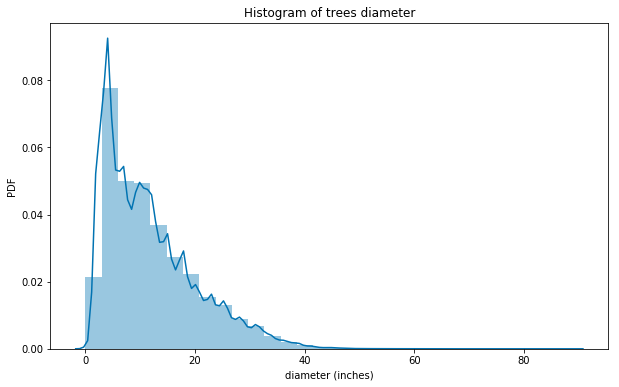

In [40]:
# Check distribution of trees' diameter
diam_data=df_tree_enc['tree_diam'].values
diam_mean=np.mean(diam_data)
diam_std=np.std(diam_data)
print('Diameter mean value: ',diam_mean)
print('Diameter standard deviation: ',diam_std)

# Plot histogram
_ = plt.figure(figsize=(10,6))
_ = plt.title('Histogram of trees diameter')
_ = plt.xlabel('diameter (inches)')
_ = plt.ylabel('PDF')
_ = sns.distplot(diam_data, bins=30)

The trees' diameter is clearly not normally distributed. For confirmation, its empirical cumulative density function can be compared to the one from a normal distribution having the same mean and standard deviation. Moreover, the distribution looks similar to a gamma distribution. 

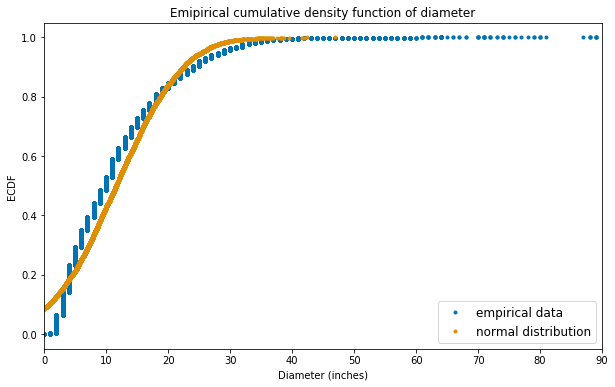

In [41]:
# Creat normal distribution with same mean and std
diam_norm=np.random.normal(diam_mean,diam_std,size=10000)

# Define function to calculate empirical cumulative density function
# and apply it to empirical and normal data of trees' diameter
def ecdf(data):
    n=len(data)
    x=np.sort(data)
    y = np.arange(1, n+1) / n
    return(x,y)   

emp_x, emp_y=ecdf(diam_data)
norm_x,norm_y=ecdf(diam_norm)

# Plot ECDFs
_ = plt.figure(figsize=(10,6))
_ = plt.plot(emp_x, emp_y, marker='.',linestyle='none',label='empirical data')
_ = plt.plot(norm_x, norm_y, marker='.',linestyle='none',label='normal distribution')
_ = plt.xlim([0,90])
_ = plt.title('Emipirical cumulative density function of diameter')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')
_ = plt.legend(fontsize='large',loc='lower right')

The ecdf plot confirms that the distribution isn't normal. Next, the same function is plotted for the five boroughs separately, to check if the distribution is the same regardless of location.

c:\users\silvia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


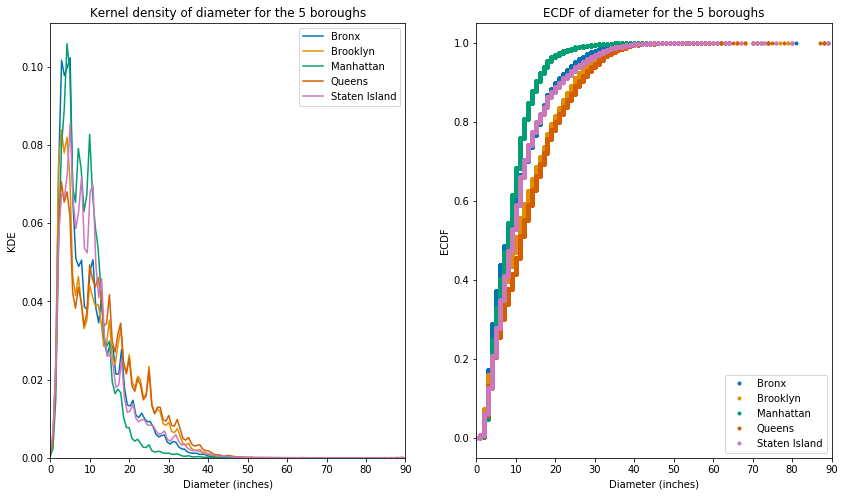

In [42]:
data_manh=df_manh['tree_diam'].values
data_queens=df_queens['tree_diam'].values
data_brook=df_brook['tree_diam'].values
data_bronx=df_bronx['tree_diam'].values
data_state=df_state['tree_diam'].values

data_list=[data_bronx,data_brook,data_manh,data_queens,data_state]

_ = plt.figure(figsize=(14,8))

for i,data in enumerate(data_list):
    x,y=ecdf(data)
    
    _ = plt.subplot(1,2,1)
    _ = sns.kdeplot(data,shade=False,label=bor_list[i],bw=0.5)
    _ = plt.xlim([0,90])
    _ = plt.title('Kernel density of diameter for the 5 boroughs')
    _ = plt.xlabel('Diameter (inches)')
    _ = plt.ylabel('KDE')
    _ = plt.legend(fontsize='medium')    
    
    _ = plt.subplot(1,2,2)
    _ = plt.plot(x,y,marker='.',linestyle='none',label=bor_list[i])
    _ = plt.xlim([0,90])
    _ = plt.title('ECDF of diameter for the 5 boroughs')
    _ = plt.xlabel('Diameter (inches)')
    _ = plt.ylabel('ECDF')
    _ = plt.legend(fontsize='medium')  


The five boroughs seem to have similar distributions, but different values of the parameters. It looks like Queens and Brooklyn and Staten Island and Bronx have a similar value of the parameters. Manhattan instead differs from all the other boroughs. This can be confirmed by permutation sampling.

In [43]:
# Define function to generate permutation sample from 2 data sets
def perm_sample(data1,data2):
    data=np.concatenate((data1,data2))
    perm_data = np.random.permutation(data)
    perm_sam1 = perm_data[:len(data1)]
    perm_sam2 = perm_data[len(data1):]
    return(perm_sam1, perm_sam2)

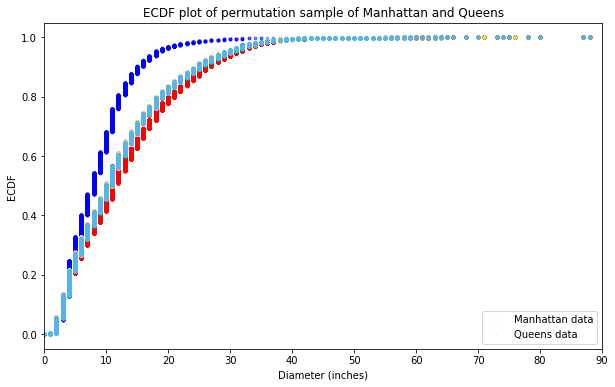

In [44]:
# Apply function to data from Manhattan and Queens, which seems to have different distributions
#ECDF of empirical data
xm,ym=ecdf(data_manh)
xq,yq=ecdf(data_queens)


_ = plt.figure(figsize=(10,6))
_ = plt.xlim([0,90])
_ = plt.title('ECDF plot of permutation sample of Manhattan and Queens')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')

_ = plt.plot(xm,ym, marker='.', linestyle='none', label='Manhattan data', color='b',
                 alpha=0.02)
_ = plt.plot(xq,yq, marker='.', linestyle='none', label='Queens data', color='r',
                 alpha=0.02)
_ = plt.legend() 

for _ in range(50):
    sam1,sam2=perm_sample(data_manh,data_queens)
    x1, y1 = ecdf(sam1)
    x2, y2 = ecdf(sam2)
    # Plot ECDFs of permutation sample
    _ = plt.plot(x1, y1, marker='.', linestyle='none')
    _ = plt.plot(x2, y2, marker='.', linestyle='none')

   

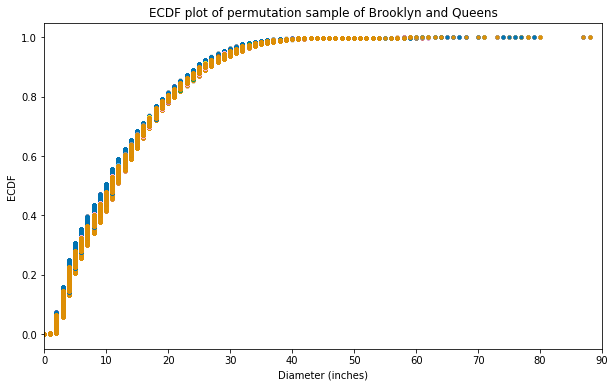

In [45]:
# Apply function to data from Brooklyn and Queens, which seems to have similar distributions

#ECDF of empirical data
xb,yb=ecdf(data_brook)


_ = plt.figure(figsize=(10,6))
_ = plt.xlim([0,90])
_ = plt.title('ECDF plot of permutation sample of Brooklyn and Queens')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')

_ = plt.plot(xb,yb, marker='.', linestyle='none', label='Brooklyn data', 
                 alpha=0.02)
_ = plt.plot(xq,yq, marker='.', linestyle='none', label='Queens data', 
                 alpha=0.02)


for _ in range(50):
    sam1,sam2=perm_sample(data_brook,data_queens)
    x1, y1 = ecdf(sam1)
    x2, y2 = ecdf(sam2)
    # Plot ECDFs of permutation sample
    _ = plt.plot(x1, y1, marker='.', linestyle='none')
    _ = plt.plot(x2, y2, marker='.', linestyle='none')

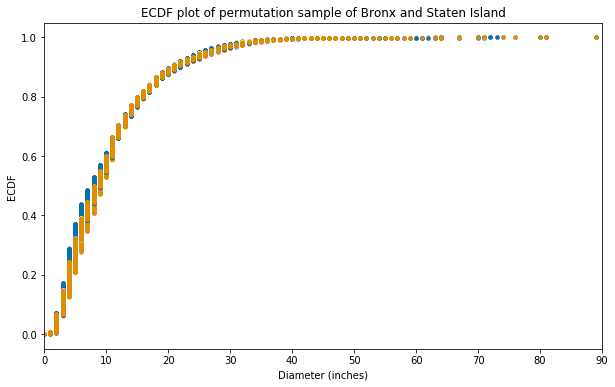

In [46]:
# Apply function to data from Bronx and Staten Island, which seems to have similar distributions

#ECDF of empirical data
xbr,ybr=ecdf(data_bronx)
xst,yst=ecdf(data_state)


_ = plt.figure(figsize=(10,6))
_ = plt.xlim([0,90])
_ = plt.title('ECDF plot of permutation sample of Bronx and Staten Island')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')

_ = plt.plot(xbr,ybr, marker='.', linestyle='none', label='Bronx data', 
                 alpha=0.02)
_ = plt.plot(xst,yst, marker='.', linestyle='none', label='Staten Island data', 
                 alpha=0.02)

for _ in range(50):
    sam1,sam2=perm_sample(data_bronx,data_state)
    x1, y1 = ecdf(sam1)
    x2, y2 = ecdf(sam2)
    # Plot ECDFs of permutation sample
    _ = plt.plot(x1, y1, marker='.', linestyle='none')
    _ = plt.plot(x2, y2, marker='.', linestyle='none')

After gaining some insight on the distribution of the only continuous variable (tree's diameter), the other variables that can be included in the model are looked at. These are categorical variables previously encoded. A chi-squared test of independence is conducted to verify the relation between each categorical variable and the health (dependent) variable. A significance level of 0.05 is chosen. For each test, if the p-value is less than the significance level, the corresponding variable is kept to be possibly used in the model.

In [47]:
# Set significance level. 
alpha=0.05

#Define function that creates contingency table (using crosstab from Pandas) 
# and runs chi squared test of indepence
# The arguments are the dataframe columns
def chi_squared_col(col1,col2):
    chi_sq,p_val,dof,exp=scs.chi2_contingency(pd.crosstab(index=col2,columns=col1))
    return(chi_sq,p_val)   

# Define function to apply chi-squared test between the dependent variable (health)
# and the other categorical variables, one at a time
# The first argument is the dependent variable (series)
# The second argument is a dataframe of the independent variables
def chi_squared(dvar,df_x,alpha):
    chi_list=[]
    p_list=[]
    for name in df_x.columns:
        chi_list.append(chi_squared_col(dvar,df_x[name])[0])
        p_list.append(chi_squared_col(dvar,df_x[name])[1])
        if chi_squared_col(dvar,df_x[name])[1] <= alpha: 
            print('With a {} significance level,{} and {} are dependent'.format(alpha,dvar.name,name))
        else: print('With a {} significance level, {} and {} are independent'.format(alpha,dvar.name,name))    
    return(chi_list,p_list)    

In [48]:
# list of encoded variables, not including health
enc_list1=['curb_loc', 'steward',
       'guards', 'sidewalk', 'user_type','root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other']

# dataframe of independent variables
df_x=df_tree_enc[enc_list1].copy()

# dependent variable (series)
df_y=df_tree_enc['health'].copy()

In [49]:
chi_squared(df_y,df_x,alpha)

With a 0.05 significance level,health and curb_loc are dependent
With a 0.05 significance level,health and steward are dependent
With a 0.05 significance level,health and guards are dependent
With a 0.05 significance level,health and sidewalk are dependent
With a 0.05 significance level,health and user_type are dependent
With a 0.05 significance level,health and root_stone are dependent
With a 0.05 significance level,health and root_grate are dependent
With a 0.05 significance level,health and root_other are dependent
With a 0.05 significance level,health and trunk_wire are dependent
With a 0.05 significance level,health and trnk_light are dependent
With a 0.05 significance level,health and trnk_other are dependent
With a 0.05 significance level,health and brch_light are dependent
With a 0.05 significance level,health and brch_shoe are dependent
With a 0.05 significance level,health and brch_other are dependent


([21.614120895345046,
  82.28058899094036,
  575.5905616284023,
  268.8651218555784,
  833.340419074703,
  602.6893353413006,
  358.1959576869471,
  1927.8368841740626,
  510.73642907210893,
  42.67209496490234,
  11801.268387986183,
  410.1067176559157,
  38.6203564609854,
  15131.719415618416],
 [2.0255981047077033e-05,
  1.2067206565534319e-15,
  4.2879826598936715e-121,
  4.136953133765446e-59,
  4.605329672693281e-179,
  1.3417564129025166e-131,
  1.6547640158664838e-78,
  0.0,
  1.244496196140663e-111,
  5.418415597270094e-10,
  0.0,
  8.840111958042204e-90,
  4.108621646534285e-09,
  0.0])

In [50]:
# define a couple of function to extract boroughs features and visually inspect correlation

def bor_xy(df):
    
    ''' function to create X,y for each borough to use in model'''
    
    X=df.copy()
    X.drop(['created_at','species','problems','borough','borocode','nta_name','latitude','longitude'],
           axis=1,inplace=True)
    y=X['health']
    X.drop(['health'],axis=1,inplace=True)
    return X,y

def pvmat(df):
    
    ''' create matrices of chi-squared and p-values of independent variables
    plot (half) heatmap of p-values'''
    
    #unroll dataframe rows and columns
    pairs=[(i,j) for i in df.columns.values for j in df.columns.values]
    chi2,p2=[],[]
    c=len(df.columns.values) 
    
    # apply chi-squared test of independence to variables, 2 at a time
    for p in pairs:
        if p[0] != p[1]:
            chi2.append(chi_squared_col(df[p[0]],df[p[1]])[0])
            p2.append(chi_squared_col(df[p[0]],df[p[1]])[1])
        else:      # for same factor pair
            chi2.append(0)
            p2.append(0)
           
    chi2 = np.array(chi2).reshape((c,c)) 
    chi2_df = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) 
    p2 = np.array(p2).reshape((c,c)) 
    p_df = pd.DataFrame(p2, index=df.columns.values, columns=df.columns.values) 
    _ = plt.figure(figsize=(10,6))
    _ = sns.heatmap(p_df,linewidths=0.5,cmap="YlGnBu")
   

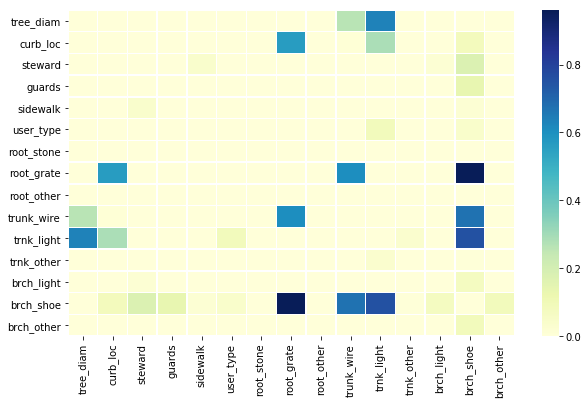

In [51]:
# Apply functions to boroughs dataframes and inspect results
# Remove features that show correlation
# Manhattan
Xman,yman=bor_xy(manh_enc)
pvmat(Xman)

In [52]:
# remove correlated dependent variables
Xman.drop(['sidewalk','root_stone','root_other','trnk_other'],axis=1,inplace=True)

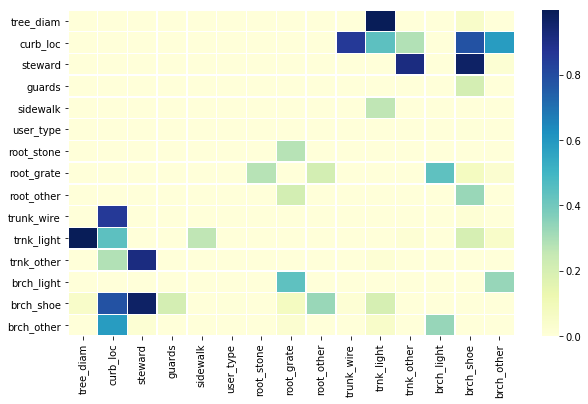

In [53]:
# Repeat for the other boroughs
Xbro,ybro=bor_xy(bronx_enc)
pvmat(Xbro)

In [54]:
# remove correlated dependent variables
Xbro.drop(['user_type'],axis=1,inplace=True)

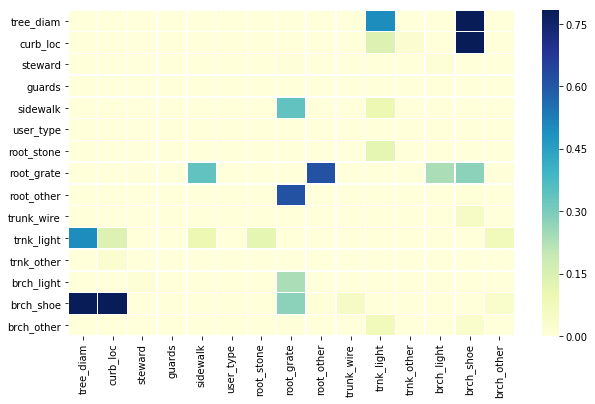

In [55]:
# Queens
Xqu,yqu=bor_xy(queens_enc)
pvmat(Xqu)

In [56]:
# remove correlated dependent variables
Xqu.drop(['steward','guards','user_type','trnk_other'],axis=1,inplace=True)

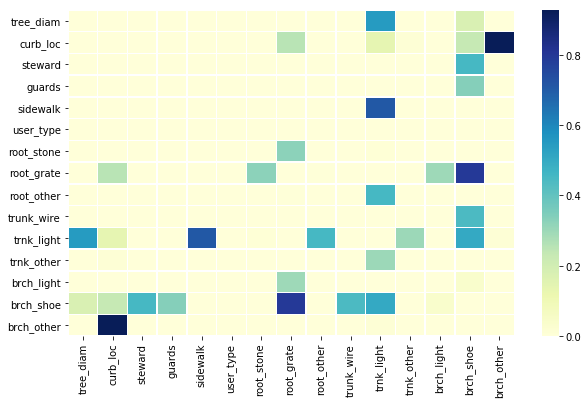

In [57]:
# Brooklin
Xbrk,ybrk=bor_xy(brook_enc)
pvmat(Xbrk)

In [58]:
# remove correlated dependent variables
Xbrk.drop(['user_type'],axis=1,inplace=True)

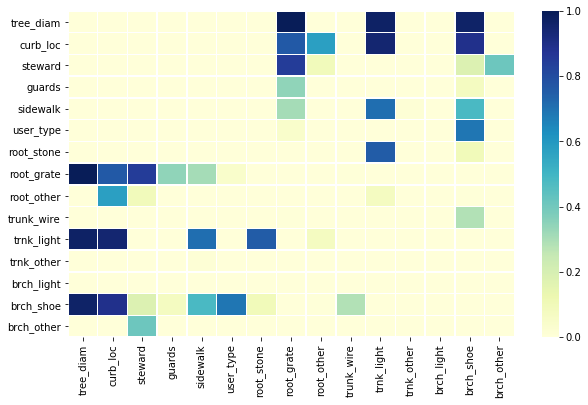

In [59]:
# Staten Island
Xsti,ysti=bor_xy(state_enc)
pvmat(Xsti)

In [60]:
# remove correlated dependent variables
Xsti.drop(['trnk_other','brch_light'],axis=1,inplace=True)

CLASSIFIER

For the classifier model, initially three options are considered and compared: Logistic Regression, KNN and Random Forest. First, out-of-the box models are created, then a grid search is implemented. Precision, recall and f1-score are used as metrics. Initially the models are built on Manhattan's data, to get an insight of how they perform.

In [61]:
# Define function that split the data in train/test sets and then uses a sampler to balance (data are unbalanced) 
# For comparison purposes, also the original unbalanced data are used
random=27
tsize=0.2

def split_sample(X,y,sampler):
    
    '''function to split data into training and test set,
    sample only training set'''
       
    Xtr, Xtst, ytr, ytst = train_test_split(X,y,test_size=tsize,random_state=random)
    sampler = sampler(random_state=0)
    Xres, yres = sampler.fit_resample(Xtr, ytr)
    return Xres, Xtst, yres, ytst

# create function to compare classifiers out-of-the-box 
def compare(Xtr,Xtst,ytr,ytst):
    
    ''' compare out-of-the-box classifiers '''
    
    lgreg=LogisticRegression(random_state=random, solver='newton-cg',multi_class='multinomial',max_iter=200)
    lgreg.fit(Xtr,ytr)
    ylrg_pred = lgreg.predict(Xtst)

    knn=KNeighborsClassifier(n_neighbors=6)
    knn.fit(Xtr,ytr)
    yknn_pred = knn.predict(Xtst)

    rf=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
    rf.fit(Xtr,ytr)
    yrf_pred = rf.predict(Xtst)

    print('The report for Logistic Regression is: \n', classification_report(ytst, ylrg_pred))
    print('')
    print('The report for KNN is: \n', classification_report(ytst, yknn_pred))
    print('')
    print('The report for Random Forest is: \n', classification_report(ytst, yrf_pred))
    print('')
    print('The confusion matrix for Logistic Regression is: \n', confusion_matrix(ytst, ylrg_pred))
    print('')
    print('The confusion matrix for KNN is: \n', confusion_matrix(ytst, yknn_pred))
    print('')
    print('The confusion matrix for Random Forest is: \n', confusion_matrix(ytst, yrf_pred))
    print('')

In [62]:
# create Mahattan train/test split on data as is (unbalanced)
Xtru, Xtstu, ytru, ytstu = train_test_split(Xman,yman,test_size=tsize,random_state=random)

# compare classifiers
compare(Xtru, Xtstu, ytru, ytstu)

The report for Logistic Regression is: 
               precision    recall  f1-score   support

           0       0.50      0.01      0.02      2330
           1       0.76      1.00      0.86      9426
           2       0.00      0.00      0.00       728

    accuracy                           0.76     12484
   macro avg       0.42      0.34      0.29     12484
weighted avg       0.66      0.76      0.65     12484


The report for KNN is: 
               precision    recall  f1-score   support

           0       0.25      0.15      0.19      2330
           1       0.77      0.90      0.83      9426
           2       0.22      0.02      0.04       728

    accuracy                           0.71     12484
   macro avg       0.42      0.36      0.35     12484
weighted avg       0.64      0.71      0.67     12484


The report for Random Forest is: 
               precision    recall  f1-score   support

           0       0.23      0.26      0.24      2330
           1       0.81   

c:\users\silvia\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As expected, on the unbalanced dataset, the algorithms have highest scores on the majority class. Logistic Regression and KNN aren't able to predict the minority classes, while Random Forest with the "balance" option gives better results for such classes. But it's worse for the class with the majority of data.
Next, sampling is used to provide a balanced dataset to the algorithms.

In [63]:
Xtr_sam, Xtst_sam, ytr_sam, ytst_sam = split_sample(Xman,yman,SMOTEENN)

# compare classifiers
compare(Xtr_sam, Xtst_sam, ytr_sam, ytst_sam)

The report for Logistic Regression is: 
               precision    recall  f1-score   support

           0       0.32      0.12      0.17      2330
           1       0.79      0.90      0.84      9426
           2       0.15      0.16      0.15       728

    accuracy                           0.71     12484
   macro avg       0.42      0.39      0.39     12484
weighted avg       0.66      0.71      0.68     12484


The report for KNN is: 
               precision    recall  f1-score   support

           0       0.22      0.28      0.25      2330
           1       0.78      0.63      0.70      9426
           2       0.08      0.19      0.11       728

    accuracy                           0.54     12484
   macro avg       0.36      0.37      0.35     12484
weighted avg       0.63      0.54      0.58     12484


The report for Random Forest is: 
               precision    recall  f1-score   support

           0       0.27      0.21      0.23      2330
           1       0.79   

Next, a grid search is done for KNN and Random Forest classifiers. 

In [64]:
# define functions for grid search on KNN and Random Forest classifiers

def knn_grid_search(Xtr, Xtst, ytr, ytst,grid):
    
    '''function to perform a grid search based on f1 score, 
    use best parameters to train and test a KNN classifier'''
   
    knn = KNeighborsClassifier()

    # Instantiate the GridSearchCV object
    # for scoring of the multiclass classification, None, 'macro', 'weighted' can be chosen 
    knn_cv = GridSearchCV(knn, grid, cv=5, scoring='f1_weighted')
    knn_cv.fit(Xtr,ytr)
    print("KNN tuned Parameters: {}".format(knn_cv.best_params_)) 
    #print("Best score is {}".format(knn_cv.best_score_))
    print('')
    
    # Fit classifier with best parameters found
    n=knn_cv.best_params_['n_neighbors']
    p=knn_cv.best_params_['p']
    alg=knn_cv.best_params_['algorithm']

    knn=KNeighborsClassifier(n_neighbors=n, algorithm=alg, p=p)
    knn.fit(Xtr,ytr)
    ypred = knn.predict(Xtst)
    print("KNN classification report: \n", classification_report(ytst, ypred))
    print("KNN confusion matrix: \n", confusion_matrix(ytst, ypred))   
    print('')
    return n,p,alg

    

def rf_grid_search(Xtr, Xtst, ytr, ytst,grid):
    
    '''function to perform a grid search based on f1 score, 
    use best parameters to train and test a Random Forest classifier'''
   
    rf = RandomForestClassifier()

    # Instantiate the GridSearchCV object
    # for scoring of the multiclass classification, None, 'macro', 'weighted' can be chosen 
    rf_cv = GridSearchCV(rf, grid, cv=5, scoring='f1_weighted')
    rf_cv.fit(Xtr,ytr)
    print("Random Forest Tuned Parameters: {}".format(rf_cv.best_params_)) 
    print('')

    #print("Best score is {}".format(knn_cv.best_score_))
    
    # Fit classifier with best parameters found
    nt=rf_cv.best_params_['n_estimators']
    cr=rf_cv.best_params_['criterion']
    
    rf=RandomForestClassifier(n_estimators=nt, criterion=cr, random_state=random)
    rf.fit(Xtr,ytr)
    ypred = rf.predict(Xtst)
    print("Random Forest classification report: \n",classification_report(ytst, ypred))
    print('')
    print("Random Forest confusion matrix: \n", confusion_matrix(ytst, ypred))   
    print('')
    return(nt,cr)


In [65]:
# define parameters grids for the classifiers
n_space=np.arange(2, 10)
alg_space=['ball_tree','kd_tree','brute']
p_space=[1,2]
k_grid=[{'n_neighbors': n_space,'p': p_space,'algorithm': alg_space}]

tree_space=[10,50,100,200,500]
criteria=['gini','entropy']

rf_grid=[{'n_estimators': tree_space, 'criterion': criteria}]

In [66]:
# grid search and results
k,p,algo=knn_grid_search(Xtr_sam, Xtst_sam, ytr_sam, ytst_sam,k_grid)
tree,criterion=rf_grid_search(Xtr_sam, Xtst_sam, ytr_sam, ytst_sam,rf_grid)

KNN tuned Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 2, 'p': 2}

KNN classification report: 
               precision    recall  f1-score   support

           0       0.22      0.29      0.25      2330
           1       0.78      0.65      0.71      9426
           2       0.08      0.16      0.11       728

    accuracy                           0.56     12484
   macro avg       0.36      0.37      0.36     12484
weighted avg       0.63      0.56      0.59     12484

KNN confusion matrix: 
 [[ 683 1366  281]
 [2253 6164 1009]
 [ 217  393  118]]

Random Forest Tuned Parameters: {'criterion': 'entropy', 'n_estimators': 200}

Random Forest classification report: 
               precision    recall  f1-score   support

           0       0.25      0.22      0.23      2330
           1       0.78      0.78      0.78      9426
           2       0.10      0.15      0.12       728

    accuracy                           0.64     12484
   macro avg       0.38      0.38      0.38 

Even with the grid search, the classifiers give similar results and an f1-score still below 0.5 for the less represented classes. To gain more insight, the training and testing accuracy of KNN vs the number of neighbors is plotted, as well as the feature importance of Random Forest. 

Text(0, 0.5, 'Accuracy')

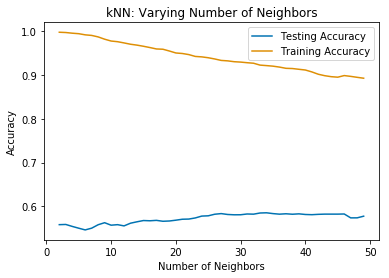

In [67]:
neighbors=np.arange(2, 50)
knn_train_accuracy = np.empty(len(neighbors))
knn_test_accuracy = np.empty(len(neighbors))
# Loop over different values of k
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm=algo, p=p)
    knn.fit(Xtr_sam, ytr_sam)
        #Compute accuracy on the training set
    knn_train_accuracy[i] = knn.score(Xtr_sam, ytr_sam)
    #Compute accuracy on the testing set
    knn_test_accuracy[i] = knn.score(Xtst_sam, ytst_sam)
plt.title('kNN: Varying Number of Neighbors')
plt.plot(neighbors, knn_test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, knn_train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

In [68]:
rf=RandomForestClassifier(n_estimators=tree, criterion=criterion,random_state=random)
rf.fit(Xtr_sam, ytr_sam)
feature_importances = pd.DataFrame(rf.feature_importances_, index = Xman.columns,
                                    columns=['importance'])#.sort_values('importance', ascending=False)
feature_importances

,importance
tree_diam,0.447390
curb_loc,0.042577
steward,0.084140
guards,0.105767
user_type,0.124439
root_grate,0.038104
trunk_wire,0.020546
trnk_light,0.005587
brch_light,0.021564
brch_shoe,0.000416


One more option to gain insight is to use PCA to see how many features explain much of the data variance.

Text(0, 0.5, 'variance')

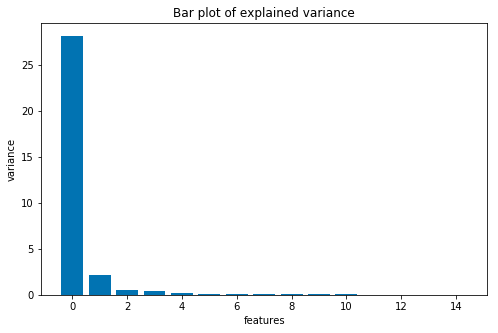

In [69]:
Xn,yn=bor_xy(manh_enc)
pca = PCA()
pca.fit(Xn)

features=range(pca.n_components_)

plt.figure(figsize=(8,5))
plt.bar(features,pca.explained_variance_)
plt.title('Bar plot of explained variance')
plt.xlabel('features')
plt.ylabel('variance')

The "problems" column is reintroduced to see if the results improve.

In [70]:
# keep the "problems" column
def bor_xy_prob(df):
    
    ''' function to create X,y for each borough to use in model'''
    
    X=df.copy()
    X.drop(['created_at','species','borough','borocode','nta_name','latitude','longitude'],
           axis=1,inplace=True)
    y=X['health']
    X.drop(['health'],axis=1,inplace=True)
    return X,y

In [71]:
Xman1,yman1=bor_xy_prob(manh_enc)
Xman1.head()

,tree_diam,problems,curb_loc,steward,guards,sidewalk,user_type,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,11,None,1,0,1,1,2,0,0,0,0,0,0,0,0,0
1,11,None,1,0,1,1,2,0,0,0,0,0,0,0,0,0
2,9,MetalGrates,1,3,2,1,2,0,1,0,0,0,0,0,0,0
3,14,"RootOther,TrunkOther,BranchOther",1,0,3,0,2,0,0,1,0,0,1,0,0,1
4,4,None,1,3,2,1,1,0,0,0,0,0,0,0,0,0


In [72]:
Xman1['problems'].value_counts()[:10]

None                      38411
Stones                     8262
BranchOther                2357
TrunkOther                 1829
RootOther                  1822
MetalGrates                1513
Stones,BranchOther         1061
Stones,TrunkOther           762
Stones,RootOther            702
TrunkOther,BranchOther      697
Name: problems, dtype: int64

In [73]:
# encode problems as yes/no, 1/0
Xman1['problems'] = [1 if p!='None' else 0 for p in Xman1.problems]
Xman1.head()

,tree_diam,problems,curb_loc,steward,guards,sidewalk,user_type,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,11,0,1,0,1,1,2,0,0,0,0,0,0,0,0,0
1,11,0,1,0,1,1,2,0,0,0,0,0,0,0,0,0
2,9,1,1,3,2,1,2,0,1,0,0,0,0,0,0,0
3,14,1,1,0,3,0,2,0,0,1,0,0,1,0,0,1
4,4,0,1,3,2,1,1,0,0,0,0,0,0,0,0,0


In [74]:
# repeat previuos steps, split data, sample and compare classifiers
Xtr1_sam, Xtst1_sam, ytr1_sam, ytst1_sam = split_sample(Xman1,yman1,SMOTEENN)

# compare classifiers
compare(Xtr1_sam, Xtst1_sam, ytr1_sam, ytst1_sam)

The report for Logistic Regression is: 
               precision    recall  f1-score   support

           0       0.25      0.35      0.29      2330
           1       0.81      0.69      0.75      9426
           2       0.13      0.21      0.16       728

    accuracy                           0.60     12484
   macro avg       0.40      0.42      0.40     12484
weighted avg       0.67      0.60      0.63     12484


The report for KNN is: 
               precision    recall  f1-score   support

           0       0.23      0.40      0.29      2330
           1       0.80      0.53      0.64      9426
           2       0.08      0.24      0.12       728

    accuracy                           0.49     12484
   macro avg       0.37      0.39      0.35     12484
weighted avg       0.65      0.49      0.54     12484


The report for Random Forest is: 
               precision    recall  f1-score   support

           0       0.23      0.38      0.29      2330
           1       0.80   

For all the classifiers, recall has improved for the first class, while the score on the second (the majority class) has decresead. The scores of the third class haven't changed much.

In [75]:
# Instead of decoding the problems into "yes/no", all the possible problems are encoded
Xman2,yman2=bor_xy_prob(manh_enc)

#label_enc(manh_enc.problems)
Xman2,yman2=bor_xy_prob(manh_enc)
Xman2['prob_enc']=label_enc(Xman2.problems)
Xman2.drop(['problems'],axis=1,inplace=True)
Xman2.head()

,tree_diam,curb_loc,steward,guards,sidewalk,user_type,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,prob_enc
0,11,1,0,1,1,2,0,0,0,0,0,0,0,0,0,38
1,11,1,0,1,1,2,0,0,0,0,0,0,0,0,0,38
2,9,1,3,2,1,2,0,1,0,0,0,0,0,0,0,4
3,14,1,0,3,0,2,0,0,1,0,0,1,0,0,1,53
4,4,1,3,2,1,1,0,0,0,0,0,0,0,0,0,38


In [76]:
# try with all problems encoded
Xtr2_sam, Xtst2_sam, ytr2_sam, ytst2_sam = split_sample(Xman2,yman2,SMOTEENN)

# compare classifiers
compare(Xtr2_sam, Xtst2_sam, ytr2_sam, ytst2_sam)

The report for Logistic Regression is: 
               precision    recall  f1-score   support

           0       0.25      0.16      0.19      2330
           1       0.80      0.81      0.80      9426
           2       0.13      0.25      0.17       728

    accuracy                           0.65     12484
   macro avg       0.39      0.41      0.39     12484
weighted avg       0.66      0.65      0.65     12484


The report for KNN is: 
               precision    recall  f1-score   support

           0       0.23      0.34      0.28      2330
           1       0.80      0.66      0.72      9426
           2       0.11      0.19      0.14       728

    accuracy                           0.57     12484
   macro avg       0.38      0.40      0.38     12484
weighted avg       0.66      0.57      0.61     12484


The report for Random Forest is: 
               precision    recall  f1-score   support

           0       0.24      0.35      0.29      2330
           1       0.80   

Next, the "species" column in considered to be included as a feature

In [77]:
df_manh[df_manh['health']=='Poor']['species'].value_counts()[:10]  

ginkgo               491
littleleaf linden    461
Callery pear         441
London planetree     381
honeylocust          205
Japanese zelkova     204
Sophora              186
American linden      184
pin oak              134
American elm          78
Name: species, dtype: int64

In [78]:
df_manh[df_manh['health']=='Fair']['species'].value_counts()[:10]  

honeylocust          2010
Callery pear         1473
London planetree     1144
ginkgo                982
littleleaf linden     796
pin oak               719
Sophora               713
Japanese zelkova      619
American linden       379
northern red oak      266
Name: species, dtype: int64

In [79]:
df_manh[df_manh['health']=='Good']['species'].value_counts()[:10]  

honeylocust          10955
Callery pear          5382
ginkgo                4386
pin oak               3730
Sophora               3554
Japanese zelkova      2773
London planetree      2597
littleleaf linden     2076
American elm          1361
American linden       1020
Name: species, dtype: int64

The same species are present in the three classes, so they might be difficult to separate them.

Next, a different downsampling is used, instead of the SMOTEE

In [80]:
# define functions
from sklearn.utils import resample

def custom_downsamp_xy(X,y,random):
    
    '''custom function to downsample majority classes'''
    
    # X,y after train/test split 
    
    df=pd.concat([X,y],axis=1)
        
    print('Classes before downsampling: \n',df['health'].value_counts())
    print('')
    
    # separate classes
    df_fair=df[df['health']==0]
    df_good=df[df['health']==1]
    df_poor=df[df['health']==2]
    
    
    samples=len(df_poor)
    
    # Downsample majority classes
    df_fair_down = resample(df_fair, 
                                 replace=False,    # sample without replacement
                                 n_samples=samples,     # to match minority class
                                 random_state=random) # reproducible results
    
    df_good_down = resample(df_good, 
                                 replace=False,    # sample without replacement
                                 n_samples=samples,     # to match minority class
                                 random_state=random) # reproducible results

    # Combine minority class with downsampled majority classes
    df_down = pd.concat([df_fair_down, df_good_down, df_poor])
 
    # Display new class counts
    print('Classes after downsampling: \n', df_down.health.value_counts())
    print('')
    
    ys=df_down['health']
    df_down.drop(['health'],axis=1,inplace=True)
    Xs=df_down.copy()
    return Xs,ys

def split_sample_custom(X,y,random):
    
    '''function to split data into training and test set,
    sample only training set'''
    
    # stratify keeps the proportions of labels 
    Xtr, Xtst, ytr, ytst = train_test_split(X,y,test_size=tsize,random_state=random, stratify=y)
    Xres, yres = custom_downsamp_xy(Xtr, ytr,random)
    return Xres, Xtst, yres, ytst

In [81]:
# use the data that includes the "problems" encoded
Xtr3_sam, Xtst3_sam, ytr3_sam, ytst3_sam=split_sample_custom(Xman2,yman2,random)
compare(Xtr3_sam, Xtst3_sam, ytr3_sam, ytst3_sam)

Classes before downsampling: 
 1    37880
0     9166
2     2887
Name: health, dtype: int64

Classes after downsampling: 
 2    2887
1    2887
0    2887
Name: health, dtype: int64

The report for Logistic Regression is: 
               precision    recall  f1-score   support

           0       0.22      0.20      0.21      2291
           1       0.83      0.57      0.68      9471
           2       0.10      0.52      0.17       722

    accuracy                           0.50     12484
   macro avg       0.38      0.43      0.35     12484
weighted avg       0.67      0.50      0.56     12484


The report for KNN is: 
               precision    recall  f1-score   support

           0       0.19      0.47      0.27      2291
           1       0.81      0.43      0.57      9471
           2       0.11      0.27      0.15       722

    accuracy                           0.43     12484
   macro avg       0.37      0.39      0.33     12484
weighted avg       0.66      0.43      0.49   

This type of sampling improved the recall of the minority classes (except for RF) and the precision of the majority one. This is something desirable.

Next, a better approach is considered, i.e. using cross-validation on the training set.

In [87]:
# this function prints out metrics for each class. Due to the fact the the original dataset is unbalanced, 
# using the average metrics might not be the best thing to do; although they are still evaluated. Also, 
# for a multiclass classification problem not all the scores are available, only "macro" and "weighted".

from sklearn.metrics import auc,precision_score,recall_score, f1_score, roc_curve
from scipy import interp
from sklearn.preprocessing import LabelBinarizer


def class_metrics(ytest,ypred,ypred_pro):
    lb = LabelBinarizer()
    lb.fit(ytest)
    classes=lb.classes_
    ytst_tra = lb.transform(ytest)
    ypred_tra = lb.transform(ypred)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in classes:
        fpr[i], tpr[i], _ = roc_curve(ytst_tra[:, i], ypred_pro[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print('ROC AUC of class {0:d}: {1:0.4f}'.format(i,roc_auc[i]))
        print('Precision, recall, f1-score of class {0:d}: {1:0.2f} {2:0.2f} {3:0.2f}'.format(i,
            precision_score(ytst_tra[:, i],ypred_tra[:, i]),
            recall_score(ytst_tra[:, i],ypred_tra[:, i]),  
            f1_score(ytst_tra[:, i],ypred_tra[:, i])))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytst_tra.ravel(), ypred_pro.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in classes: mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    print('Micro-average ROC AUC {0:0.4f}: '.format(roc_auc["micro"]))
    print('Macro-average ROC AUC {0:0.4f}: '.format(roc_auc["macro"]))
    print('')
    

In [88]:
# use the data that includes the "problems" encoded
# StratifiedKFold create folds with data proportional to the original
# here, instead of applying directly the grid search function available from sklearn,
# a loop is printed to go through the folds and print the scores 

from sklearn.model_selection import StratifiedKFold


skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

# use the data that include the "problems" encoded and the sampling/split with SMOTEE
# Xtr2_sam, Xtst2_sam, ytr2_sam, ytst2_sam 

for tr_ind, tst_ind in skf.split(Xtr2_sam, ytr2_sam):
    Xtr, Xtst = Xtr2_sam[tr_ind], Xtr2_sam[tst_ind]
    ytr, ytst = ytr2_sam[tr_ind], ytr2_sam[tst_ind]
    rf=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
    rf.fit(Xtr,ytr)
    ypred=rf.predict(Xtst)
    ypred_prob=rf.predict_proba(Xtst)
    class_metrics(ytst,ypred,ypred_prob)

ROC AUC of class 0: 0.9991
Precision, recall, f1-score of class 0: 0.98 0.98 0.98
ROC AUC of class 1: 0.9995
Precision, recall, f1-score of class 1: 0.99 0.98 0.99
ROC AUC of class 2: 0.9997
Precision, recall, f1-score of class 2: 0.98 0.99 0.99
Micro-average ROC AUC 0.9994: 
Macro-average ROC AUC 0.9994: 

ROC AUC of class 0: 0.9997
Precision, recall, f1-score of class 0: 0.98 0.99 0.99
ROC AUC of class 1: 0.9998
Precision, recall, f1-score of class 1: 1.00 0.98 0.99
ROC AUC of class 2: 0.9999
Precision, recall, f1-score of class 2: 0.99 1.00 0.99
Micro-average ROC AUC 0.9998: 
Macro-average ROC AUC 0.9998: 

ROC AUC of class 0: 0.9994
Precision, recall, f1-score of class 0: 0.97 0.99 0.98
ROC AUC of class 1: 0.9996
Precision, recall, f1-score of class 1: 1.00 0.97 0.98
ROC AUC of class 2: 0.9999
Precision, recall, f1-score of class 2: 0.99 1.00 0.99
Micro-average ROC AUC 0.9994: 
Macro-average ROC AUC 0.9996: 

ROC AUC of class 0: 0.9994
Precision, recall, f1-score of class 0: 0.98 0

Cross-validation on the training data shows very good results!

In [89]:
rf=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
rf.fit(Xtr2_sam, ytr2_sam)
ypred_new=rf.predict(Xtst2_sam)
ypred_prob_new=rf.predict_proba(Xtst2_sam)
class_metrics(ytst_sam,ypred_new,ypred_prob_new)

ROC AUC of class 0: 0.5681
Precision, recall, f1-score of class 0: 0.24 0.35 0.29
ROC AUC of class 1: 0.6097
Precision, recall, f1-score of class 1: 0.80 0.68 0.74
ROC AUC of class 2: 0.5949
Precision, recall, f1-score of class 2: 0.12 0.20 0.15
Micro-average ROC AUC 0.7504: 
Macro-average ROC AUC 0.5909: 



But, as seen before, performances aren't great on the test set.

In [92]:
# Repeat for Knn, which will probably lead to similar results.
skfk= StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

for tr_ind, tst_ind in skfk.split(Xtr2_sam, ytr2_sam):
    Xtr, Xtst = Xtr2_sam[tr_ind], Xtr2_sam[tst_ind]
    ytr, ytst = ytr2_sam[tr_ind], ytr2_sam[tst_ind]
    knn=KNeighborsClassifier(n_neighbors=6)
    knn.fit(Xtr,ytr)
    ypredk=knn.predict(Xtst)
    ypredk_prob=knn.predict_proba(Xtst)
    class_metrics(ytst,ypredk,ypredk_prob)

print('')    
knn.fit(Xtr2_sam, ytr2_sam)
ypredk_new=knn.predict(Xtst2_sam)
ypredk_prob_new=knn.predict_proba(Xtst2_sam)
class_metrics(ytst2_sam,ypredk_new,ypredk_prob_new)    

ROC AUC of class 0: 0.9922
Precision, recall, f1-score of class 0: 0.92 0.95 0.93
ROC AUC of class 1: 0.9951
Precision, recall, f1-score of class 1: 0.98 0.94 0.96
ROC AUC of class 2: 0.9962
Precision, recall, f1-score of class 2: 0.96 0.97 0.96
Micro-average ROC AUC 0.9945: 
Macro-average ROC AUC 0.9945: 

ROC AUC of class 0: 0.9951
Precision, recall, f1-score of class 0: 0.92 0.96 0.94
ROC AUC of class 1: 0.9971
Precision, recall, f1-score of class 1: 0.99 0.94 0.96
ROC AUC of class 2: 0.9979
Precision, recall, f1-score of class 2: 0.96 0.97 0.96
Micro-average ROC AUC 0.9966: 
Macro-average ROC AUC 0.9967: 

ROC AUC of class 0: 0.9940
Precision, recall, f1-score of class 0: 0.92 0.96 0.94
ROC AUC of class 1: 0.9934
Precision, recall, f1-score of class 1: 0.98 0.93 0.95
ROC AUC of class 2: 0.9985
Precision, recall, f1-score of class 2: 0.95 0.98 0.97
Micro-average ROC AUC 0.9949: 
Macro-average ROC AUC 0.9953: 

ROC AUC of class 0: 0.9939
Precision, recall, f1-score of class 0: 0.93 0

In [94]:
# use randomized grid search to tune hyperparameter
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [10, 20, 50, 100, 200],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10],
    'criterion': ['gini','entropy'],
#    'class_weight': w
    
}

cla_rf=RandomForestClassifier()
gri_rf = RandomizedSearchCV(cla_rf, rf_param_grid, cv=5, scoring='f1_macro')
gri_rf.fit(Xtr2_sam, ytr2_sam)

print('Best params: ',gri_rf.best_params_)

# Fit classifier with best parameters found
nsp=gri_rf.best_params_['min_samples_split']
nt=gri_rf.best_params_['n_estimators']
md=gri_rf.best_params_['max_depth']
mf=gri_rf.best_params_['max_features']
cr=gri_rf.best_params_['criterion']
    
best_rf=RandomForestClassifier(n_estimators=nt, criterion=cr, random_state=random, max_features=mf,
                              min_samples_split=nsp,max_depth=md)
best_rf.fit(Xtr2_sam, ytr2_sam)
ypred_best_rf = best_rf.predict(Xtst2_sam)
ypred_best_rf_prob=best_rf.predict_proba(Xtst2_sam)
class_metrics(ytst2_sam,ypred_best_rf,ypred_best_rf_prob)

Best params:  {'n_estimators': 50, 'min_samples_split': 5, 'max_features': 10, 'max_depth': 25, 'criterion': 'gini'}
ROC AUC of class 0: 0.5668
Precision, recall, f1-score of class 0: 0.24 0.34 0.28
ROC AUC of class 1: 0.6056
Precision, recall, f1-score of class 1: 0.81 0.69 0.75
ROC AUC of class 2: 0.5883
Precision, recall, f1-score of class 2: 0.13 0.20 0.16
Micro-average ROC AUC 0.7592: 
Macro-average ROC AUC 0.5869: 

